In [82]:
#!/usr/bin/env python
# coding: utf-8
import numpy
import sys
from operator import itemgetter
import scipy
import numpy as np

import scipy.optimize as opt
from scipy import stats
from tqdm import tqdm
import pandas as pd
numpy.random.seed(1)
import argparse
from scipy.optimize import minimize
import diptest
from scipy.stats import chi2

In [83]:
counts_dir='/Users/hannahjacobs/MIT Dropbox/Hannah Jacobs/GradSchool/Finucane/splicing_variation_in_humans_2022/GTEx sQTLs/GTEx_Analysis_v8_sQTL_leafcutter_counts/'

data_directory='/Users/hannahjacobs/MIT Dropbox/Hannah Jacobs/GradSchool/Finucane/splicing_variation_in_humans_2022/data/00_data/emp_bayes_input/'

In [84]:



# # Modelling PSI variation among individuals with hierarchical binomial models
# 
# Background
# --
# Consider a binary alternative splicing event, such as a skipped exon or a pair of alternative 3' or 5' splice sites. In both cases there is an exon segment that can either be included or skipped. In the case of the skipped exon, the entire exon is either included or excluded. In the case of the alternative splice sites, the segment of sequence between the two splice sites is either included or excluded. In each case, there are two possible isoforms: an inclusion form and an exclusion form.
# 
# How frequently the variable sequence is included rather than excluded is generally termed  𝜓  (PSI, or percent-spliced-in). If  𝜆𝐼  is the amount of inclusion-form generated by the cell and  𝜆𝐸  is the amount of exclusion-form, then  𝜓  is defined
# 
# 𝜓=𝜆𝐼𝜆𝐼+𝜆𝐸
#  
# But we never have access to those true rates. Instead, we generally try to estimate PSI from noisy sequencing data. In this setting, we usually have sequencing read counts supporting exon-exon junctions which belong to either the inclusion or exclusion forms. In the case of skipped exons, there are two junctions supporting the inclusion form, which needs to be accounted for when estimating PSI. Because this complicates matters slightly, we'll instead focus on alternative splice sites where both the inclusion and exclusion form are each supported by a single exon-exon junction.
# 
# Let's call the number of reads supporting the inclusion form  𝑟  and the number of reads supporting the exclusion form  𝑞 . The total number of reads supporting the binary splicing event is  𝑛=𝑟+𝑞 . We want to infer  𝜓  from the observed read counts  𝑟  and  𝑞 . A naive approach would to just compute the ratio
# 
# 𝜓̂ =𝑟𝑟+𝑞
#  
# This, however, has several undesirable quantities. The most disastrous is that it does not account for noisy count data can be. If  𝑟+𝑞  is small, this estimator  𝜓̂   is likely to vary considerably around the true  𝜓 . But a more subtle problem is that this estimator assumes that absence of evidence is evidence of absence. That is, it can estimate  𝜓̂   equals zero or one, and will tend to do so when  𝑟+𝑞  is small.

# In[289]:


tissue='Adipose_subcutaneous'
tissue_file=counts_dir+tissue+'_perind_numers.counts.gz'
filter_file=data_directory+'skipped_exons_w_gene_names_and_assigned_abc_introns.csv.gz'

counts=pd.read_csv(tissue_file, compression='gzip', sep=' ', index_col=0)

skipped_exons=pd.read_csv(filter_file, compression='gzip')



In [85]:


#merged based on tissue and cluster ID
unskipped_1=skipped_exons[0::3]

skipped=skipped_exons[1::3]

unskipped_2=skipped_exons[2::3]

counts_w_ID = counts.reset_index().rename(columns={'index':'ID'})

counts_w_ID['tissue']=tissue

#print(skipped_exons.ID)
#print(unskipped_1.ID)
#print(skipped.ID)
#print(unskipped_2.ID)

skipped_counts_give_tissue = skipped[['ID', 'tissue']].merge(counts_w_ID, on = ['ID', 'tissue'], how = 'inner')
    
unskipped_1_counts_give_tissue = unskipped_1[['ID', 'tissue']].merge(counts_w_ID, on = ['ID', 'tissue'], how = 'inner')

unskipped_2_counts_give_tissue = unskipped_2[['ID', 'tissue']].merge(counts_w_ID, on = ['ID', 'tissue'], how = 'inner')


skipped_raw = skipped_counts_give_tissue.loc[:, ~skipped_counts_give_tissue.columns.isin(['ID', 'tissue'])].values

unskipped_raw_1 = unskipped_1_counts_give_tissue.loc[:, ~unskipped_1_counts_give_tissue.columns.isin(['ID', 'tissue'])].values

unskipped_raw_2 = unskipped_2_counts_give_tissue.loc[:, ~unskipped_2_counts_give_tissue.columns.isin(['ID', 'tissue'])].values

#apply filter for difference of a and b reads
log_ratio=(np.log(np.mean(unskipped_raw_1, axis=1)) - np.log(np.mean(unskipped_raw_2, axis=1)))

#ROUNDED TO THREE DECIMALS?
filtered_exons = (np.abs(log_ratio) <= 1)

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

In [87]:

skipped_counts_give_tissue=skipped_counts_give_tissue[filtered_exons==True]
unskipped_1_counts_give_tissue=unskipped_1_counts_give_tissue[filtered_exons==True]
unskipped_2_counts_give_tissue=unskipped_2_counts_give_tissue[filtered_exons==True]


In [88]:
sns.scatterplot(x=np.hstack(unskipped_1_counts_give_tissue.drop(columns={'ID', 'tissue'}).values)[2:10000],
            y=np.hstack(unskipped_2_counts_give_tissue.drop(columns={'ID', 'tissue'}).values)[2:10000])

ValueError: need at least one array to concatenate

In [ ]:


def combine_random_rows(df1, df2):
    # Ensure both DataFrames have the same number of rows
    if len(df1) != len(df2):
        raise ValueError("Both DataFrames must have the same number of rows.")

    selected_rows = []
    # Loop through each row index
    for i in range(len(df1)):
        # Randomly choose either 0 or 1 with equal probability
        if np.random.rand() < 0.5:
            selected_rows.append(df1.iloc[i])
        else:
            selected_rows.append(df2.iloc[i])
    
    # Create a new DataFrame from the selected rows
   # new_df = pd.DataFrame(selected_rows).reset_index(drop=True)
    new_df = pd.DataFrame(selected_rows)
    return new_df

# Use the function to create the new DataFrame
unskipped_random_chosen_counts_give_tissue = combine_random_rows(unskipped_1_counts_give_tissue, unskipped_2_counts_give_tissue)

#figure out which event is lower: skipped or unskipped
total_reads_supporting_skipped =  skipped_counts_give_tissue.loc[:, ~skipped_counts_give_tissue.columns.isin(['ID', 'tissue'])].sum(axis=1)

total_reads_supporting_unskipped = unskipped_random_chosen_counts_give_tissue.loc[:, ~unskipped_random_chosen_counts_give_tissue.columns.isin(['ID', 'tissue'])].sum(axis=1)


#pick the exon with less total reads across all individuals 
skipped_is_lower_PSI = total_reads_supporting_skipped.values <= total_reads_supporting_unskipped.values

unskipped_random_chosen_counts_give_tissue['minority_is_exclusion_event'] = skipped_is_lower_PSI

skipped_counts_give_tissue['minority_is_exclusion_event'] = skipped_is_lower_PSI

#unskipped_2_counts_give_tissue['minority_is_exclusion_event'] = skipped_is_lower_PSI

####assign cluster names
cluster_name = unskipped_1_counts_give_tissue.ID + '_' + skipped_counts_give_tissue.ID + '_' + unskipped_2_counts_give_tissue.ID.apply(lambda x: x.split(':clu')[0]) 

#unskipped_1_counts_give_tissue=unskipped_1_counts_give_tissue.assign(cluster_name=cluster_name)
#unskipped_2_counts_give_tissue=unskipped_2_counts_give_tissue.assign(cluster_name=cluster_name)
skipped_counts_give_tissue=skipped_counts_give_tissue.assign(cluster_name=cluster_name)
unskipped_random_chosen_counts_give_tissue=unskipped_random_chosen_counts_give_tissue.assign(cluster_name=cluster_name)

####assign to alphas anmd betas
a_i = skipped_counts_give_tissue[skipped_counts_give_tissue.minority_is_exclusion_event].sort_values(by='cluster_name', ascending=False)

a_2 = unskipped_random_chosen_counts_give_tissue[~unskipped_random_chosen_counts_give_tissue.minority_is_exclusion_event].sort_values(by='cluster_name', ascending=False)

b_i = unskipped_random_chosen_counts_give_tissue[unskipped_random_chosen_counts_give_tissue.minority_is_exclusion_event].sort_values(by='cluster_name', ascending=False)

b_2 = skipped_counts_give_tissue[~skipped_counts_give_tissue.minority_is_exclusion_event].sort_values(by='cluster_name', ascending=False)

#prepare for optimizer
a=pd.concat([a_i, a_2])
b=pd.concat([b_i, b_2])


cluster_names = a.cluster_name

skipped_exon_type = a.minority_is_exclusion_event

alpha_counts = a.drop(columns=(['ID', 'tissue', 'minority_is_exclusion_event','cluster_name']))

beta_counts = b.drop(columns=(['ID', 'tissue', 'minority_is_exclusion_event','cluster_name']))

################### algorthm as same as alt ss now


       




output_df=a[['ID', 'tissue', 'minority_is_exclusion_event','cluster_name']]







output_df=output_df.assign(total_reads_supporting_unskipped=total_reads_supporting_unskipped)

output_df=output_df.assign(total_reads_supporting_unskipped=total_reads_supporting_skipped)



    





In [53]:
sns.set_context('poster')

In [ ]:
cluster_names

In [64]:
len(total_reads_supporting_skipped.values <= total_reads_supporting_unskipped.values)

5779

In [80]:
mean_reads_supporting_skipped =  skipped_counts_give_tissue.loc[:, ~skipped_counts_give_tissue.columns.isin(['ID', 'tissue','minority_is_exclusion_event',	'cluster_name'])].mean(axis=1)

mean_reads_supporting_unskipped = unskipped_random_chosen_counts_give_tissue.loc[:, ~unskipped_random_chosen_counts_give_tissue.columns.isin(['ID', 'tissue','minority_is_exclusion_event',	'cluster_name'])].mean(axis=1)


(0.0, 100.0)

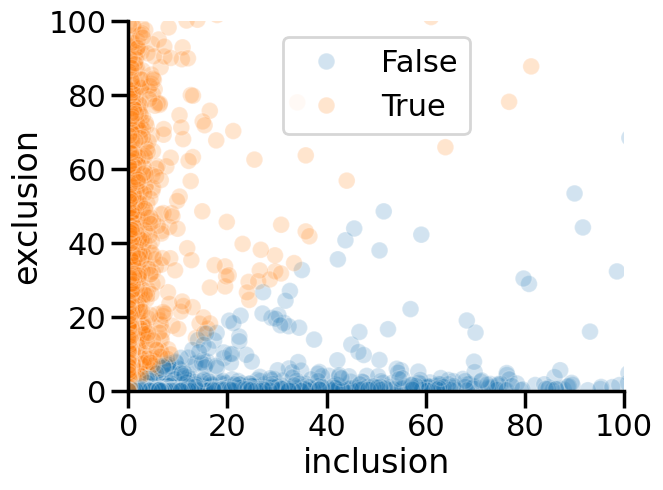

In [79]:
ax=sns.scatterplot(x=np.hstack(mean_reads_supporting_skipped.values),
            y=np.hstack(mean_reads_supporting_unskipped.values), alpha=0.2, hue=skipped_is_lower_PSI)

sns.despine()
ax.set_ylabel('exclusion')
ax.set_xlabel('inclusion')
ax.set_ylim([0,100])
ax.set_xlim([0,100])

(0.0, 1000.0)

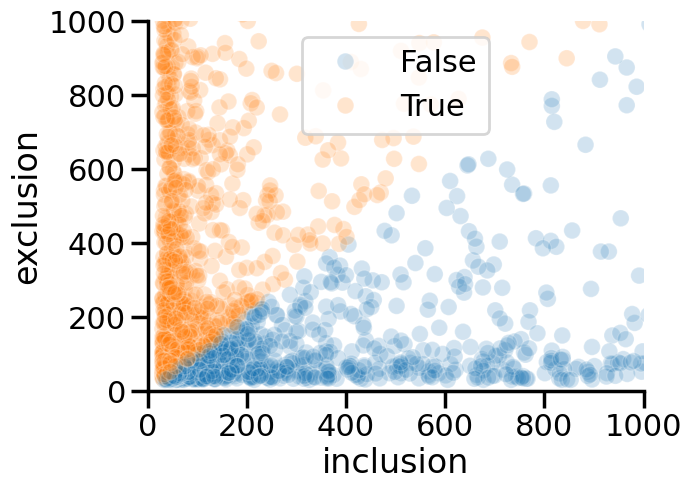

In [68]:
ax=sns.scatterplot(x=np.hstack(total_reads_supporting_skipped.values),
                    y=np.hstack(total_reads_supporting_unskipped.values), 
                   alpha=0.2, hue=skipped_is_lower_PSI)

sns.despine()
ax.set_ylabel('exclusion')
ax.set_xlabel('inclusion')
ax.set_ylim([0,1000])
ax.set_xlim([0,1000])